In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import precision_recall_curve, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
Result = pd.DataFrame()
tmp = pd.DataFrame()
models = [GradientBoostingRegressor(), RandomForestRegressor(), LinearRegression()]

#Кросс-валидация:
for model in models:
    model_name = str(model)
    scores = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True)
        score = cross_val_score(estimator=model, X=x, y=y, cv=fold, scoring='r2')
        scores = np.append(scores, score)
    tmp['Оценки качества'] = pd.Series(scores)
    tmp['Модель'] = model_name
    Result = Result.append(tmp)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [27]:
def submission(predict, ind, filename, targetname, indexname):
    predicted_df = pd.DataFrame(predict, index = np.arange(ind, predict.shape[0] + ind), columns = [targetname])
    predicted_df.to_csv(filename, index_label=indexname)

In [3]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

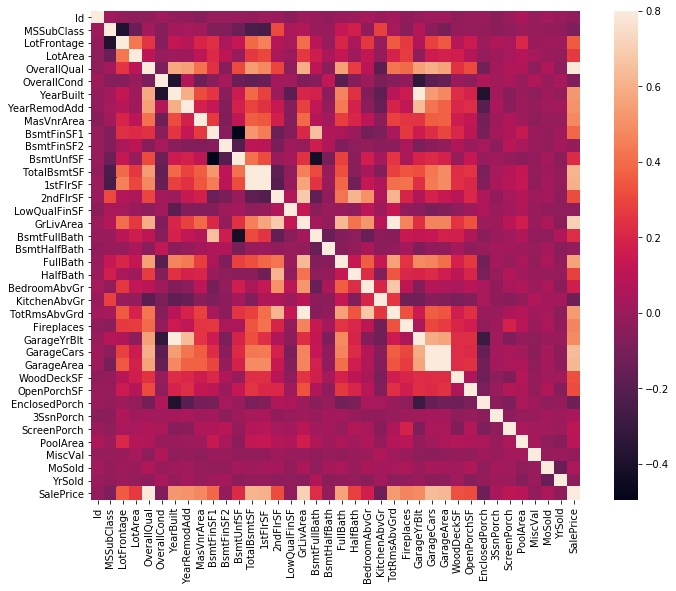

In [4]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [5]:
columns = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd']

In [6]:
y = train_data['SalePrice']
test_id = test_data['Id']
all_data = pd.concat([train_data, test_data], axis=0, sort=False)
all_data = all_data.drop(['Id', 'SalePrice'], axis=1)
all_data.reset_index(drop=True, inplace=True)

In [7]:
# X = train_data.drop(columns = ['SalePrice', 'Id'])
# test_data = test_data.drop(columns = 'Id')
# y = train_data['SalePrice']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Проверим пропущенные значения. Удалим те признаки, в которых больше 45% пропусков

In [8]:
miss_values = (all_data.isna().sum()/all_data.shape[0]).sort_values(ascending=False)
miss_values.head(10)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
dtype: float64

In [9]:
drop_columns_miss = miss_values[miss_values > 0.45].index
all_data = all_data.drop(columns = drop_columns_miss)

Посмотрим на признаки. Заметим, что много категориальных

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

Признак не несет много информации, если большая часть наблюдений принимает лишь одно значение. Удали те признаки, уникальное значение которых принимает больше 85% 

In [11]:
cat_col = list(all_data.select_dtypes(include='object'))
drop_columns_cat = []
for col in cat_col:
    if (all_data[col].value_counts(1) > 0.85)[0]:
        #print(all_data[col].value_counts(1)*100)
        drop_columns_cat.append(col)

In [12]:
all_data = all_data.drop(columns = drop_columns_cat)
print('Удалили', len(drop_columns_cat), 'категориальных признаков')

Удалили 18 категориальных признаков


То же самое для числовых признаков

In [13]:
num_columns = list(all_data.select_dtypes(include=['float64', 'int64']))
drop_columns_num = []
for col in num_columns:
    if list(all_data[col].value_counts(1) > 0.85)[0]:
        #print(all_data[col].value_counts(1)*100)
        drop_columns_num.append(col)

In [14]:
all_data = all_data.drop(columns = drop_columns_num)
print('Удалили', len(drop_columns_num), 'числовых признаков')

Удалили 8 числовых признаков


In [15]:
num_columns = list(all_data.select_dtypes(include=['float64', 'int64']))
cat_columns = list(all_data.select_dtypes(include='object'))


смотрим корреляцию

In [16]:
train_data_corr = train_data[all_data.columns]
train_data_corr['SalePrice'] = train_data['SalePrice']

In [17]:
s=(abs(train_data_corr.corrwith(train_data_corr['SalePrice'])).sort_values(ascending=False)>0.5)
num_columns_corr = list(s[s==True].index[1:])


In [18]:
all_data = all_data[num_columns_corr+cat_columns]

Заполним пропуски в данных. Числовые признаки заполняем медианой, категориальные - модой

In [19]:
print(all_data.dtypes.unique())
num_columns = list(all_data.select_dtypes(include=['float64', 'int64']))
cat_columns = list(all_data.select_dtypes(include='object'))

[dtype('int64') dtype('float64') dtype('O')]


In [20]:
for col in cat_columns:
    all_data[col].fillna(all_data[col].mode()[0], inplace = True)     
for col in num_columns:
    all_data[col].fillna(all_data[col].median(), inplace = True)

In [21]:
all_data = pd.get_dummies(all_data, columns=cat_columns, drop_first=True)

# Cлучайный лес

In [22]:
X = all_data[:len(y)]
test = all_data[len(y):]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.metrics import mean_squared_log_error

def cv_rmsle(model, X, y, kf):
    return np.sqrt(abs(np.mean(cross_val_score(model, X, y, 
                                               scoring="neg_mean_squared_log_error", n_jobs=-1, cv=kf))))

In [28]:
forest = RandomForestRegressor(random_state=17)

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=17)
print('CV metrics', cv_rmsle(forest, X_train, y_train, skf))

forest.fit(X, y)
predict_tree = forest.predict(test)
submission(predict=predict_tree, ind=1461, filename = 'tree_base.csv', targetname = 'SalePrice', indexname = 'Id' )

CV metrics 0.16215726942519354


In [29]:
predict_tree = forest.predict(X_test)
#submission(predict=predict_tree, ind=1461, filename = 'tree_base.csv', targetname = 'SalePrice', indexname = 'Id' )

# XGB

In [31]:
import xgboost as XGB

the_model = XGB.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
the_model.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints=None,
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, subsample=0.5213,
             tree_method=None, validate_parameters=False, verbosity=None)

In [35]:
xgb_predict = the_model.predict(test)
submission(predict=xgb_predict, ind=1461, filename = 'xgb_base.csv', targetname = 'SalePrice', indexname = 'Id' )

# 1. Линейная регрессия

In [ ]:
X = all_data[:len(y)]
test = all_data[len(y):]

Нормирование

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_data_scaled = scaler.transform(test_data)

In [24]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
linreg_predict = linreg.predict(X_test_scaled)
linreg_predict_test = linreg.predict(test_data_scaled)

In [28]:
from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(y_test, linreg_predict)
root = np.sqrt(msle)
root

0.17202463130813245

In [29]:
def submission(predict, ind, filename, targetname, indexname):
    predicted_df = pd.DataFrame(predict, index = np.arange(ind, predict.shape[0] + ind), columns = [targetname])
    predicted_df.to_csv(filename, index_label=indexname)

In [30]:
submission(predict=linreg_predict_test, ind=1461, filename = 'linreg.csv', targetname = 'SalePrice', indexname = 'Id' )

# Lasso

In [31]:
from sklearn.linear_model import LassoCV
alphas = np.logspace(-6, 2, 200)

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=17)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06, 1.58856513e-06, 1.74263339e-06, 1.91164408e-06,
       2.09704640e-06, 2.30043012e-06, 2.52353917e-06, 2.76828663e-06,
       3.03677112e-06, 3.33129479e-06, 3.65438307e-06, 4.00880633e-06,
       4.39760361e-06, 4.82410870e-06, 5.29197874e-06, 5.80522552e-06,
       6.36824994e-06, 6.98587975e-0...
       3.61234270e+01, 3.96268864e+01, 4.34701316e+01, 4.76861170e+01,
       5.23109931e+01, 5.73844165e+01, 6.29498899e+01, 6.90551352e+01,
       7.57525026e+01, 8.30994195e+01, 9.11588830e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=17, selection='cyclic', tol=0.0001,
        verbose=False)

In [33]:
lasso_cv.alpha_

100.0

In [34]:
def coef(model):
    model_coef = pd.DataFrame(abs(model.coef_), X.columns, columns=['coef'])
    model_coef=model_coef.sort_values(by='coef', ascending=False)
    return model_coef

In [37]:
lasso_cv_coef = coef(lasso_cv)
#lasso_cv_coef[lasso_cv_coef['coef']==0]

In [38]:
lasso_cv_coef

,coef
BsmtQual_TA,16143.010112
BsmtQual_Gd,15268.028180
KitchenQual_TA,14116.266095
OverallQual,13538.103056
GrLivArea,12835.304005
...,...
Exterior2nd_CmentBd,0.000000
Exterior2nd_HdBoard,0.000000
Exterior2nd_VinylSd,0.000000
MasVnrType_None,0.000000
